# Collaborative filtering
The idea is to build an item-based CF recommender. This method uses ratings of all users to determine similarity between books and then recommends the most similar books to the ones the user liked.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
users = pd.read_csv('../data/BX-Users.csv',encoding='ISO-8859-1',sep= ';')
ratings = pd.read_csv('../data/BX-Book-Ratings.csv',encoding='ISO-8859-1',sep= ';')
books = pd.read_csv('../data/books.csv')

In [3]:
df = pd.merge(pd.merge(ratings , users), books)
df = df[['User-ID', 'ISBN', 'Book-Rating', 'title']]
df.head()

,User-ID,ISBN,Book-Rating,title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


The data is loaded into one pandas dataframe, that contains ratings, the user ID and the book ISBN and title. Firstly, it is needed to remove all the implicit (0) ratings from the dataset. This unfortunately removes a large subset of data, however, for the method used, it is needed to have the valid ratings.

In [4]:
print("Statistics before removing 0 ratings")
print(str(df.shape [0]) +" ratings")
print(df['User-ID'].nunique() ," users")
print(df['ISBN'].nunique(), " books")

Statistics before removing 0 ratings
462694 ratings
59865  users
113333  books


In [5]:
df = df[(df['Book-Rating'] > 0)]
print("Statistics after removing 0 ratings")
print(str(df.shape [0]) +" ratings")
print(df['User-ID'].nunique() ," users")
print(df['ISBN'].nunique(), " books")

Statistics after removing 0 ratings
179200 ratings
43374  users
65306  books


<AxesSubplot:>

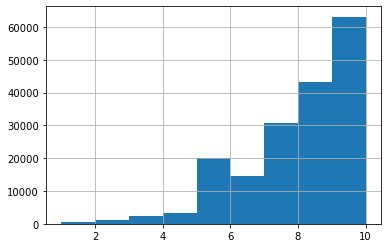

In [6]:
df['Book-Rating'].hist(bins=9)

In [7]:
df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
title          0
dtype: int64

Now that we have a valid dataset, we need to define a threshold of number of ratings in order to remove book with few ratings. This removes books with low popularity and simplifies the calculation as it reduces the dataset size. At the moment, only books with >10 ratings are considered.

In [8]:
overview = df.groupby('title')['Book-Rating'].agg('count').sort_values(ascending=False)
overview = pd.DataFrame(overview)
overview = overview[overview['Book-Rating'] > 10]
overview

,Book-Rating
title,
The Lovely Bones: A Novel,707
Wild Animus,581
The Da Vinci Code,491
The Nanny Diaries: A Novel,393
The Red Tent (Bestselling Backlist),383
...,...
Blood Test,11
Harmful Intent,11
The Sorcerer's Companion: A Guide to the Magical World of Harry Potter,11


In [9]:
df = df[df.title.isin(overview.index.array)]
df.shape

(77746, 4)

For the recommender validation, 1% of ratings is moved to the testing dataframe.

In [10]:
df_train, df_test = train_test_split(df, test_size=0.01, random_state=1)

In [11]:
print(df_train.shape)
print(df_test.shape)

(76968, 4)
(778, 4)


From the train dataset we build a matrix of ratings. The method requires NaN values to be filled with zeros.

In [12]:
matrix = df_train.pivot_table(index=['User-ID'],columns=['title'],values = 'Book-Rating').fillna(0)
matrix.head()

title,10 Lb. Penalty,"14,000 Things to Be Happy About",1984,1st to Die: A Novel,2010: Odyssey Two,2061: Odyssey Three,253,2nd Chance,4 Blondes,50 Simple Things You Can Do to Save the Earth,...,You Shall Know Our Velocity,You're Only Old Once! : A Book for Obsolete Children,Young Wives,Yukon Ho!,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zodiac: The Eco-Thriller,\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",iI Paradiso Degli Orchi,stardust
User-ID,,,,,,,,,,,,,,,,,,,,,
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we build the item-item similarity matrix. The similarity function used is the pearson correlation, the similarity between items is thus expressed in correlation coefficient.

In [13]:
corr_matrix = matrix.corr(method='pearson')
corr_matrix.head()

title,10 Lb. Penalty,"14,000 Things to Be Happy About",1984,1st to Die: A Novel,2010: Odyssey Two,2061: Odyssey Three,253,2nd Chance,4 Blondes,50 Simple Things You Can Do to Save the Earth,...,You Shall Know Our Velocity,You're Only Old Once! : A Book for Obsolete Children,Young Wives,Yukon Ho!,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zodiac: The Eco-Thriller,\O\ Is for Outlaw,"\Surely You're Joking, Mr. Feynman!\: Adventures of a Curious Character",iI Paradiso Degli Orchi,stardust
title,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,1.000000,-0.000518,-0.001422,0.042179,-0.000743,0.025049,-0.000484,0.012696,-0.000965,-0.000605,...,-0.000669,-0.000483,-0.000641,-0.000621,-0.001237,-0.000654,0.043983,-0.000562,-0.000570,-0.000710
"14,000 Things to Be Happy About",-0.000518,1.000000,-0.001326,0.038677,-0.000692,-0.000569,0.062967,0.017314,-0.000900,-0.000564,...,-0.000624,0.074173,0.046679,0.052348,0.022351,0.055763,0.026271,-0.000524,-0.000532,0.044742
1984,-0.001422,-0.001326,1.000000,0.013391,0.055929,-0.001561,-0.001238,-0.004230,-0.002469,-0.001549,...,0.014634,-0.001235,-0.001640,-0.001589,0.032853,0.059942,-0.002867,-0.001439,-0.001459,0.024768
1st to Die: A Novel,0.042179,0.038677,0.013391,1.000000,0.005347,-0.002335,0.018216,0.160733,-0.003693,0.009560,...,0.020663,0.042756,0.025804,0.025950,0.009433,0.025906,0.068840,-0.002152,-0.002182,0.017635
2010: Odyssey Two,-0.000743,-0.000692,0.055929,0.005347,1.000000,0.131624,-0.000646,-0.002209,-0.001290,-0.000809,...,-0.000894,-0.000645,-0.000857,-0.000830,0.032887,0.018456,-0.001497,-0.000751,-0.000762,-0.000949


Now we need functions to evaluate similarity to a particular book and a book set.
- __get_simmilar__ function finds a row in the correlation matrix for a given book and multiplies it by the rating - 5.5. This ensures that higher rating give this row a higher weight and bad rating make it negative - resulting in recommending anticorrelated books.
- __recommend_books__ takes an array of books + ratings and applies get_simmilar to these, resulting in a dataframe with rows equal to the number of books in the array. For all books the final score is calculated as a mean of weighted correlation coefficients. The books with the highest score are the ones recommended.

In [14]:
def get_similar(title, rating):
    similar_ratings = corr_matrix[title]*(rating-5.5)
    similar_ratings = similar_ratings.sort_values(ascending=False)
    return similar_ratings

In [15]:
def recommend_books(user_rated_books):
    similar_books = pd.DataFrame()
    for book,rating in user_rated_books:
        similar_books = pd.concat([similar_books,get_similar(book,rating).to_frame().T],ignore_index=True)

    result = similar_books.mean().sort_values(ascending=False)
    return result

To test the recommender, let's see what a person who liked Lord of the Rings gets. Two options are tested, the user read only the Fellowship of the Ring or read the full series.

In [16]:
first_lotr_book = [("The Fellowship of the Ring (The Lord of the Rings, Part 1)",10)]

all_lotr_books = [("The Fellowship of the Ring (The Lord of the Rings, Part 1)",10),
            ("The Two Towers (The Lord of the Rings, Part 2)", 10),
            ("The Return of the King (The Lord of the Rings, Part 3)",10)]


In [17]:
recommend_books(first_lotr_book).head(20)

title
The Fellowship of the Ring (The Lord of the Rings, Part 1)                      4.500000
The Two Towers (The Lord of the Rings, Part 2)                                  1.792590
The Return of the King (The Lord of the Rings, Part 3)                          1.750275
The Hobbit : The Enchanting Prelude to The Lord of the Rings                    0.960443
The Magic School Bus Lost in the Solar System (Magic School Bus (Paperback))    0.439169
Quidditch Through the Ages                                                      0.423905
Harry Potter and the Prisoner of Azkaban (Book 3)                               0.394674
The Waste Lands (The Dark Tower, Book 3)                                        0.378955
The Drawing of the Three (The Dark Tower, Book 2)                               0.355324
Firestarter                                                                     0.344135
The Tale of the Body Thief (Vampire Chronicles (Paperback))                     0.336372
The Awakening  

In [18]:
recommend_books(all_lotr_books).head(20)

title
The Two Towers (The Lord of the Rings, Part 2)                                  2.921035
The Return of the King (The Lord of the Rings, Part 3)                          2.906930
The Fellowship of the Ring (The Lord of the Rings, Part 1)                      2.680955
The Hobbit : The Enchanting Prelude to The Lord of the Rings                    0.992747
The Silmarillion                                                                0.480326
Harry Potter and the Prisoner of Azkaban (Book 3)                               0.393081
The Hobbit: or There and Back Again                                             0.375909
Faith of the Fallen (Sword of Truth, Book 6)                                    0.352056
Cat in the Hat (I Can Read It All by Myself Beginner Books)                     0.333635
The Magic School Bus Lost in the Solar System (Magic School Bus (Paperback))    0.332151
Cat's Cradle                                                                    0.328912
House Atreides 

The Lord of the Rings fan gets the next books from the LOTR series, which seems like a good choice. Now comes the model validation. According to resources, there is no strict way how to validate the recommenders. What can be tested with our model is whether the books that would get recommended to users were well-rated by them.

The idea is to make "predictions" for ratings in the test dataset based on the train dataset. Firstly, we filter the test dataset, so it contains only users and books that are present in the train dataset. Then we calculate the score for the book in ratings dataset and compare it with the real rating. As there are many iterations in this process, the validation is a bit slow.

In [19]:
df_test.shape

(778, 4)

In [20]:
df_test1 = df_test[(df_test['User-ID'].isin(df_train['User-ID']))]
df_test2 = df_test1[(df_test1['ISBN'].isin(df_train['ISBN']))]
df_test2.shape

(588, 4)

In [21]:
def predict_rating(user_id,title):
    user_ratings = []
    user_ratings_df = df_train[df_train['User-ID'] == user_id][['title','Book-Rating']]
    for index, row in user_ratings_df.iterrows():
        user_ratings.append((row['title'],row['Book-Rating']))
    return recommend_books(user_ratings)[title]

In [22]:
df_test2['Score'] = df_test2.apply(lambda x: predict_rating(x['User-ID'], x['title']), axis=1)
df_test2

C:\Users\chess\AppData\Local\Temp\ipykernel_8532\1417330239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test2['Score'] = df_test2.apply(lambda x: predict_rating(x['User-ID'], x['title']), axis=1)


,User-ID,ISBN,Book-Rating,title,Score
30256,163433,0142001740,8,The Secret Life of Bees,0.030935
286688,135265,0515132292,9,Wild,0.039004
93398,244685,0515131229,9,Dance upon the Air (Three Sisters Island Trilogy),0.092586
95404,147680,0671024248,9,Hearts In Atlantis,0.047893
11261,228351,0060930187,8,The Bell Jar : A Novel (Perennial Classics),0.025522
...,...,...,...,...,...
114229,229741,0439136350,8,Harry Potter and the Prisoner of Azkaban (Book 3),0.068473
11367,224249,0375760911,9,The Idiot Girls' Action Adventure Club,0.041179
13723,245295,0393319296,10,Invisible Monsters,0.078014
92383,5783,0451205421,8,The Door to December,0.074099


<AxesSubplot:xlabel='Score', ylabel='Book-Rating'>

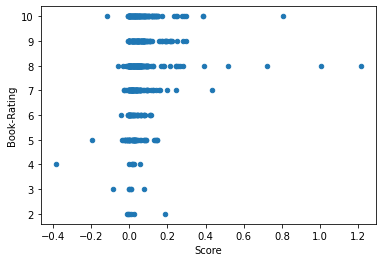

In [23]:
df_test2.plot.scatter(x='Score',y='Book-Rating')

(-0.1, 0.5)

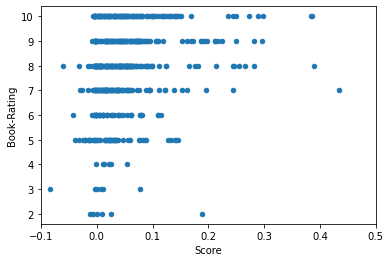

In [24]:
mypplot = df_test2.plot.scatter(x='Score',y='Book-Rating')
mypplot.set_xlim([-0.1, 0.5])

Unfortunately, at this stage, the scoring is not scalable to the book rating, we can only look whether a high score generally leads to a higher book rating. From the scatter plot, it can be seen that in fact a higher score leads to a higher rating.